# SPIRE Aperture Photometry for Point Sources

The method is for photmetry is outlined in [the SPIRE Handbook](http://herschel.esac.esa.int/Docs/SPIRE/spire_handbook.pdf), section 5.12.1. This notebook just shows one practical example.

The workflow is the following:
1. Using `ESASky` module of `astroquery` search for the source in _Herschel_ observations. Pick on observation for the example.
2. Download the map using the [astroquery.esasky](https://astroquery.readthedocs.io/en/latest/esasky/esasky.html) results.
3. Perform aperture photometry using [photutils](https://photutils.readthedocs.io/en/stable).
4. Bonus: compare the aperture-derived flux density with the one in the SPIRE point source catalogue, also available in `astroquery.esasky`.

For this exercise we are going to use a known stellar calibrator: $\beta$ And, with RA=01:09:43.9, Dec= +35:37:14.

For reference, the model flux densities of $\beta$ And in the SPIRE bands ([Decin et al. 2007](https://ui.adsabs.harvard.edu/#abs/2007A&A...472.1041D)) are (430, 217, 105) mJy at (250, 350, 500) µm. 

**Requirements**: `python 3.x`, `matplotlib 2.2.2` (in `matplotlib 3.0.0` the WCS from `astropy` is broken), `astropy`, `astroquery`, `photutils`.

In [1]:
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import hstack
from astropy.nddata import Cutout2D

import aplpy

from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry

from astroquery.esasky import ESASky

## Search in ESASky

We search for _Herschel_ maps in ESASky, using as an inpu the taret name. The search radius is set to 6" (that's one pixel of the SPIRE 250 µm map). This should be sufficient. 

In [4]:
#
# We'll seacrh ESASky for $\beta$ And directly, using the Simbad name resolver
maps = ESASky.query_region_maps("beta And", radius="6 arcsec",missions=['Herschel'])
#
# Note, this will download the maps in Maps sub-folder

## Check the ESASky results table

The results are returned in a `astropy.Table.table`. It is useful to check it.

In [5]:
#
# let's check the results table and what observations are there
#
print (maps["HERSCHEL"].info)
maps["HERSCHEL"]["observation_id","filter","duration"].pprint()

<Table masked=True length=45>
      name       dtype  format
--------------- ------- ------
   postcard_url  object       
    product_url  object       
 observation_id  object       
observation_oid   int32       
         ra_deg float64 {!r:>}
        dec_deg float64 {!r:>}
    target_name  object       
     instrument  object       
         filter  object       
     start_time  object       
       duration float64 {!r:>}
          stc_s  object       

observation_id     filter    duration
-------------- ------------- --------
    1342224965 250, 350, 500    583.0
    1342259256      100, 160    152.0
    1342223338      100, 160    276.0
    1342248031      100, 160    152.0
    1342263815 250, 350, 500    583.0
    1342248033      100, 160    276.0
    1342223336       70, 160    276.0
    1342237161      100, 160    276.0
    1342212508       70, 160    276.0
    1342199613      100, 160    276.0
           ...           ...      ...
    1342237163       70, 160    152.0
   

In [6]:
#Let's pick up SPIRE observation, i.e. one that has 250, 350, and 500 µm
# one example is 13422263815, this is index 4, we remove all the rest
nher = len(maps["HERSCHEL"])
ikeep = 4
maps["HERSCHEL"].remove_rows(np.delete(range(nher),ikeep))
maps["HERSCHEL"]["observation_id","filter","duration"].pprint()

observation_id     filter    duration
-------------- ------------- --------
    1342263815 250, 350, 500    583.0


In [7]:
# now we can download the map
maps_data = ESASky.get_maps(maps)

Starting download of HERSCHEL data. (1 files)
INFO: Maps available at /Users/ivaltcha/Dropbox/Work/Python/herspy/notebooks/Maps [astroquery.esasky.core]


In [8]:
#
# extract the HDU for the maps in a dictionary
# there should be only one index [0]
hdu = {}
spire_bands = ['250','350','500']
for band in spire_bands:
    hdu[band] = maps_data["HERSCHEL"][0][band]

## Visualise the maps

To visualise each SPIRE map we use `astropy.visualization.ImageNormalize` module, doing a colour cut at the 98% of the pixel distribution, using the `PercentileInterval`. There are many options for pixel cut ans stretch selection, so check the module documentation.

It is necessary to ignore the NaNs in during the `ImageNormalization`. 

Alternatively one can use [APLpy](https://aplpy.github.io) for visualisation.

INFO: Auto-setting vmin to -1.892e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.428e+01 [aplpy.core]


/Users/ivaltcha/miniconda3/envs/py37/lib/python3.7/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: Auto-setting vmin to -7.473e-01 [aplpy.core]
INFO: Auto-setting vmax to  7.649e+00 [aplpy.core]
INFO: Auto-setting vmin to -2.111e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.355e+00 [aplpy.core]


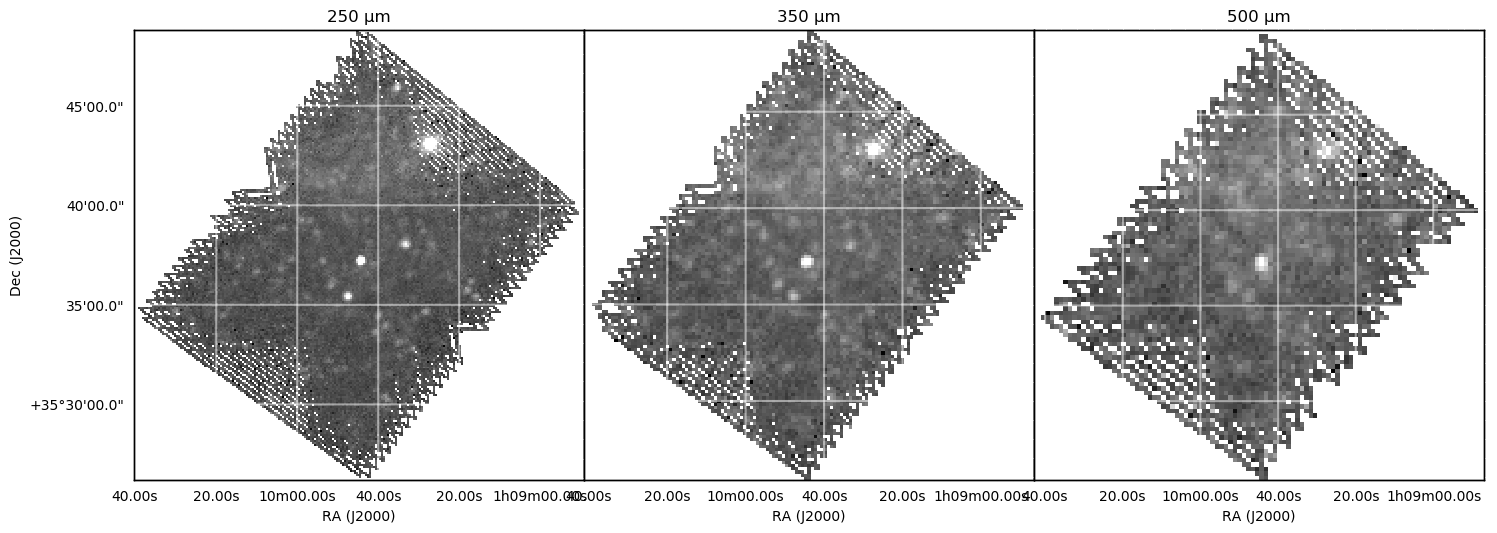

In [18]:
#
# Display the three SPIRE maps, will use colour interval is 98%.
# nan are messing the normalization, so will take care of it
#
fig = plt.figure(figsize=(15,15),dpi=100)
pp = 98.0 # 
for k,band in enumerate(spire_bands):
    f1 = aplpy.FITSFigure(hdu[band]['image'], figure=fig, subplot=[0.1+k*0.3,0.1,0.3,0.3])
    f1.show_grayscale()
    f1.set_title(f"{band} µm")
    f1.add_grid()
    if (k > 0):
        f1.hide_ytick_labels()
        f1.hide_yaxis_label()

## Converting the input maps from MJy/sr to Jy/pixel

To do aperture photmetry we need to convert the SPIRE maps to `Jy/pixel`. The pipeline produced SPIRE maps are either in units of `Jy/beam` (point-source calibrated maps) or in `MJy/sr` (extended-source calibrated maps). The maps available in `ESASky` are the extended-source calibrated ones, so they are in units of `MJy/sr`.

Doing aperture photometry of a point source starting from extended-source calibrated map will require the following steps, as explained in the SPIRE Handbook:

1. Convert to point-source calibration, dividing by `KPtoE`
2. Divide by $\Omega_\mathrm{pipe}$ to convert from _per steradian_ to _per pixel_.

After these two steps the maps should be in `Jy/pixel` and we have to set the proper unit in the header.

In [19]:
# check the map units, to make sure it's MJy/sr
print (hdu['250']['image'].header['BUNIT'])

MJy/sr


In [20]:
#
# Using the SPIRE Handbook we copy the necessary parameters
# NOTE: we also apply the same scaling for the error image!
#
KPtoE = {'250': 90.646, '350': 51.181, '500': 23.580}
# the beam solid angle in arcsec^2
omega_pipe = {'250': 469.35, '350': 831.27, '500': 1804.31} # arcsec^2
for band in spire_bands:
    wcs = WCS(hdu[band]['image'].header)
    pixscale = wcs.wcs.cdelt[1]*3600.0
    hdu[band]['image'].data = pixscale**2*hdu[band]['image'].data/KPtoE[band]/omega_pipe[band]
    hdu[band]['image'].header['BUNIT'] = 'Jy/pixel'
    hdu[band]['error'].data = pixscale**2*hdu[band]['error'].data/KPtoE[band]/omega_pipe[band]
    hdu[band]['error'].header['BUNIT'] = 'Jy/pixel'

Now the maps are in `Jy/pixel`. Let's define the coordinates of the target $\beta$ Andromeda:

In [21]:
# beta And coordinates, in degrees
ra_c = 17.43504
dec_c = 35.62010
beta_And = SkyCoord(ra=ra_c * u.deg, dec=dec_c * u.deg, frame='icrs')

And define the apertures for the target, and the background. We use the default aperture sizes as described in the SPIRE Handbook, table 5.8.

In [22]:
aperture = dict()
aperture['250'] = SkyCircularAperture(beta_And, r=22. * u.arcsec)
aperture['350'] = SkyCircularAperture(beta_And, r=30. * u.arcsec)
aperture['500'] = SkyCircularAperture(beta_And, r=40. * u.arcsec)
# and the background annuli
back = SkyCircularAnnulus(beta_And, r_in = 60.0*u.arcsec, r_out=90.0*u.arcsec)

## Integrate the total flux

Next is the actual measurement of the total flux within the target aperture and the background annulus. We do the background subtraction within the loop over the bands.

We use the `error` extension of each SPIRE map and estimate the error on the derived flux within the input aperture.

Few comments:
* the aperture areas can only be calculated if the aperture is converted to pixels. To do this the method to_pixlel() needs a WCS.
* The final result is the flux density and the error both `Jy`.

In [23]:
ap_flux = dict()
ap_flux_err = dict()
print ("band,flux,error")
for band in spire_bands:
    #photo[band] = aperture_photometry(hdu[band]['image'], aperture[band])
    img = hdu[band]['image'].data
    wcs = WCS(hdu[band]['image'].header)
    err_img = hdu[band]['error'].data
    photo = aperture_photometry(img, aperture[band],error=err_img,wcs=wcs)
    bkg_photo = aperture_photometry(img, back,wcs=wcs)
    wcs = WCS(hdu[band]['image'].header)
    bkg_area = back.to_pixel(wcs).area()
    aper_area = aperture[band].to_pixel(wcs).area()
    ap_flux[band] = photo['aperture_sum'][0] - aper_area*bkg_photo['aperture_sum'][0]/bkg_area
    ap_flux_err[band] = photo['aperture_sum_err'][0]
    print ("{},{:.4f},{:.4f} Jy".format(band,ap_flux[band],ap_flux_err[band]))

band,flux,error
250,0.3280,0.0037 Jy
350,0.1782,0.0032 Jy
500,0.0939,0.0032 Jy


## Corrections

Fow all the subsequent corrections we need the source spectrum, as the pipeline assumes a source with $\nu F_\nu$ = const. Our assumption is that in the SPIRE bands $\beta$ And has a powerlaw spectrum with an index 2 (i.e. Rayleigh-Jeans). 

We can use the tables in the SPIRE Handbook and pick up the beam correction (Table 5.5) and the colour-correction for a point source (Table 5.7).

And finally, we apply the aperture correciton, which corrects for the point-like source flux lost outside the selected aperture. The corrections for the default apertures and sources with differnet spectral index, are listed in Table 5.9. 

In [24]:
# the beam correction
kbeam = {'250': 1.0446, '350': 1.0434, '500': 1.0746} # powerlaw with alpha=2
print ("band,flux,error")
for band in spire_bands:
    ap_flux[band] = ap_flux[band]*kbeam[band]
    ap_flux_err[band] = ap_flux_err[band]*kbeam[band]
    print ("{},{:.4f},{:.4f} Jy".format(band,ap_flux[band],ap_flux_err[band]))

band,flux,error
250,0.3427,0.0038 Jy
350,0.1860,0.0033 Jy
500,0.1009,0.0034 Jy


Next we need to apply the colour correction KColP (Table 5.6)

In [25]:
# the colour correction

kcolp = {'250': 0.9454, '350': 0.9481, '500': 0.9432} # powerlaw with alpha=2
print ("band,flux,error")
for band in spire_bands:
    ap_flux[band] = ap_flux[band]*kcolp[band]
    ap_flux_err[band] = ap_flux_err[band]*kcolp[band]
    print ("{},{:.4f},{:.4f} Jy".format(band,ap_flux[band],ap_flux_err[band]))

band,flux,error
250,0.3239,0.0036 Jy
350,0.1763,0.0032 Jy
500,0.0952,0.0032 Jy


And finally the aperture correction, which is also source SED dependent (Table 5.8). Note that we use the standard apertures of (22,30,40) arcsec. For different ones the user has to use the beam profiles from the SPIRE calibration context and dervie the correction.

In [26]:
# the aperture correction

kaper = {'250': 1.28, '350': 1.242, '500': 1.2610}
print ("band,flux,error")
for band in spire_bands:
    ap_flux[band] = ap_flux[band]*kaper[band]
    ap_flux_err[band] = ap_flux_err[band]*kaper[band]
    print ("{},{:.4f},{:.4f} Jy".format(band,ap_flux[band],ap_flux_err[band]))

band,flux,error
250,0.4147,0.0046 Jy
350,0.2190,0.0039 Jy
500,0.1200,0.0041 Jy


## Comparison with models

And finally let's compare with Decin et al. (2007) models:

In [27]:
model = {'250': 430, '350': 217, '500': 105} # mJy
print ('band,measured,error,model,model/measured')
for band in spire_bands:
    print ("{},{:.2f}+/-{:.2f},{},{:.2f}".format(band,ap_flux[band]*1000, ap_flux_err[band]*1000,model[band], model[band]/ap_flux[band]/1000.0))


band,measured,error,model,model/measured
250,414.65+/-4.64,430,1.04
350,218.98+/-3.93,217,0.99
500,120.02+/-4.06,105,0.87


We can visualise the apertures and the background annuli just to make sure they make sense.

We'll use Cutout2d to zoom in.

INFO: Auto-setting vmin to -1.601e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.208e-02 [aplpy.core]
INFO: Auto-setting vmin to -1.757e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.798e-02 [aplpy.core]
INFO: Auto-setting vmin to -9.723e-04 [aplpy.core]
INFO: Auto-setting vmax to  1.546e-02 [aplpy.core]


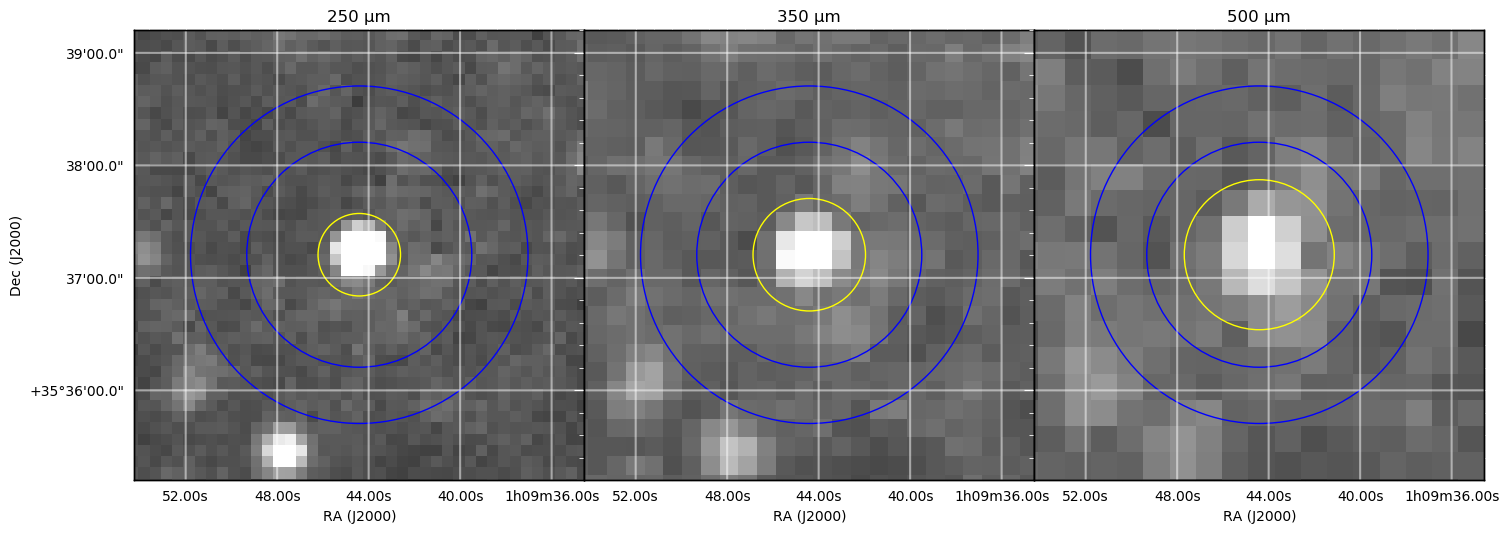

In [55]:
#
# Display the three SPIRE maps, will use colour interval is 98%.
# nan are messing the normalization, so will take care of it
#
fig = plt.figure(figsize=(15,15),dpi=100)
pp = 98.0 # 
zoomSize = u.Quantity((4.0,4.0 ), u.arcmin)
for k,band in enumerate(spire_bands):
    f1 = aplpy.FITSFigure(hdu[band]['image'], figure=fig, subplot=[0.1+k*0.3,0.1,0.3,0.3])
    f1.recenter(ra_c,dec_c, radius=2.0/60.0)
    f1.show_grayscale()
    f1.show_circles(aperture[band].positions.ra.value,aperture[band].positions.dec.value,\
                    aperture[band].r.value/3600.0,color='yellow')
    f1.show_circles(back.positions.ra.value,back.positions.dec.value,\
                    back.r_in.value/3600.0,color='blue')
    f1.show_circles(back.positions.ra.value,back.positions.dec.value,\
                    back.r_out.value/3600.0,color='blue')
    f1.set_title(f"{band} µm")
    f1.add_grid()
    if (k > 0):
        f1.hide_ytick_labels()
        f1.hide_yaxis_label()

## Compare with the SPIRE Point Source Catalogue

The first release of the SPIRE Point Source Catalogue (SPSC) is available in `ESASky`, so we can extract the photometry in there and compare with the results from the aperture photometry.


In [56]:
#
# search ESASky for $\beta$ And
#
# first, let's see what catalogues are available
ESASky.list_catalogs()

['AllWise',
 '2MASS',
 'INTEGRAL',
 'CHANDRA',
 'XMM-EPIC-STACK',
 'XMM-EPIC',
 'XMM-OM',
 'XMM-SLEW',
 'Tycho-2',
 'Gaia DR2',
 'Hipparcos-2',
 'HSC',
 'Herschel-HPPSC-070',
 'Herschel-HPPSC-100',
 'Herschel-HPPSC-160',
 'Herschel-SPSC-250',
 'Herschel-SPSC-350',
 'Herschel-SPSC-500',
 'Planck-PGCC2',
 'Planck-PCCS2E-HFI',
 'Planck-PCCS2-HFI',
 'Planck-PCCS2-LFI',
 'Planck-PSZ']

In [57]:
#
# will extract the flux, its error and signal-to-noise ratio
#
# note the flux density is for a source with power-law SED with index $\alpha$ = -1.
#
# The SPSC is based on the timeline fitter, so it only needs the colour correction, see the Handbook, flowchart 5.21.
#
spsc_f = {}
spsc_f_err = {}
print ("band, Flux (mJy), Flux_err (mJy), SNR")
for band in ['250','350','500']:
    output = ESASky.query_object_catalogs('beta And',f'Herschel-SPSC-{band}')
    spsc_f[band] = output[0]['flux'][0]*kcolp[band]
    spsc_f_err[band] = output[0]['flux_err'][0]*kcolp[band]
    print ("{}, {:.2f}, {:.2f}, {}".format(band,spsc_f[band],spsc_f_err[band],output[0]['snr'][0]))

band, Flux (mJy), Flux_err (mJy), SNR


250, 435.17, 11.63, 37.4
350, 213.89, 14.70, 14.6
500, 110.54, 8.77, 12.5


<Figure size 800x500 with 0 Axes>

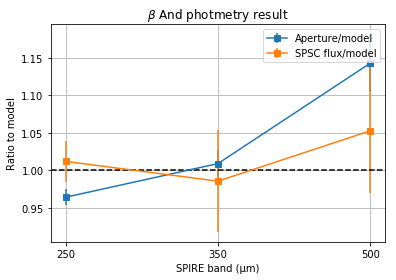

In [58]:
#
# let's see them graphically, we use the model as the baseline and do the ratio
#
spire_bands = ['250','350','500']
r1 = [] # aperture to model
r2 = [] # spsc to model
r1_err = [] # error aperture to model
r2_err = [] # error spsc to model
#
# will proagate the errors, assuming the model has zero error
#
for band in spire_bands:
    r1.append(1000*ap_flux[band]/model[band])
    r2.append(spsc_f[band]/model[band])
    r1_err.append(1000*ap_flux_err[band]/model[band])
    r2_err.append(spsc_f_err[band]/model[band])
#
#
fig = plt.figure(figsize=(8,5),dpi=100)
fig, ax = plt.subplots()
ax.axhline(y=1,color='k',ls='dashed')
ax.errorbar(spire_bands,r1,yerr=r1_err,marker='s',label='Aperture/model')
ax.errorbar(spire_bands,r2,yerr=r2_err,marker='s',label='SPSC flux/model')
ax.set_xlabel('SPIRE band (µm)')
ax.set_ylabel('Ratio to model')
ax.set_title(r'$\beta$ And photmetry result')
ax.grid(True)
ax.legend()

## The End

